# Naives Bayes Implementation

[![Twitter Handle](https://img.shields.io/badge/Twitter-@gaohongnan-blue?style=social&logo=twitter)](https://twitter.com/gaohongnan)
[![LinkedIn Profile](https://img.shields.io/badge/@gaohongnan-blue?style=social&logo=linkedin)](https://linkedin.com/in/gao-hongnan)
[![GitHub Profile](https://img.shields.io/badge/GitHub-gao--hongnan-lightgrey?style=social&logo=github)](https://github.com/gao-hongnan)
![Tag](https://img.shields.io/badge/Tag-Organized_Chaos-orange)
[![Code](https://img.shields.io/badge/View-Code-blue?style=flat-square&logo=github)](https://github.com/gao-hongnan/omniverse/blob/40957563757f7dce3fb02821b42a181426857780/omnivault/machine_learning/generative/naive_bayes.py)

```{contents}
:local:
```

## Imports and Dependencies

In [1]:
from __future__ import annotations

import sys
from pathlib import Path
import matplotlib.pyplot as plt


def find_root_dir(current_path: Path | None = None, marker: str = '.git') -> Path | None:
    """
    Find the root directory by searching for a directory or file that serves as a
    marker.

    Parameters
    ----------
    current_path : Path | None
        The starting path to search from. If None, the current working directory
        `Path.cwd()` is used.
    marker : str
        The name of the file or directory that signifies the root.

    Returns
    -------
    Path | None
        The path to the root directory. Returns None if the marker is not found.
    """
    if not current_path:
        current_path = Path.cwd()
    current_path = current_path.resolve()
    for parent in [current_path, *current_path.parents]:
        if (parent / marker).exists():
            return parent
    return None

root_dir = find_root_dir(marker='omnivault')

if root_dir is not None:
    sys.path.append(str(root_dir))
    from omnivault.utils.visualization.style import use_svg_display
    from omnivault.utils.reproducibility.seed import seed_all
else:
    raise ImportError("Root directory not found.")

import random
from functools import partial
from typing import Any, Dict, Tuple, TypeVar, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.collections import PathCollection
from rich.pretty import pprint
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits, load_iris, make_blobs
from sklearn.model_selection import train_test_split

use_svg_display()

## Implementation

In [2]:
from __future__ import annotations

import logging
import math
from typing import Any, Optional

import numpy as np
from numpy.typing import NDArray

from omnivault.machine_learning.estimator import BaseEstimator

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


# pylint: disable=too-many-instance-attributes
class NaiveBayesGaussian(BaseEstimator):
    num_samples: int
    num_features: int

    theta: NDArray[np.floating[Any]]
    pi: NDArray[np.floating[Any]]

    prior: NDArray[np.floating[Any]]
    likelihood: NDArray[np.floating[Any]]
    posterior: NDArray[np.floating[Any]]

    def __init__(self, random_state: int = 1992, num_classes: int = 3) -> None:
        self.random_state = random_state
        self.num_classes = num_classes

    def _set_num_samples_and_features(self, X: NDArray[np.floating[Any]]) -> None:
        # num_samples unused since we vectorized when estimating parameters
        self.num_samples, self.num_features = X.shape

    def fit(self, X: NDArray[np.floating[Any]], y: NDArray[np.floating[Any]]) -> NaiveBayesGaussian:
        """Fit Naive Bayes classifier according to X, y.

        Note:
            Fitting Naive Bayes involves us finding the theta and pi vector.

        Args:
            X (NDArray[np.floating[Any]]): N x D matrix
            y (NDArray[np.floating[Any]]): N x 1 vector
        """
        self._set_num_samples_and_features(X)

        # Calculate the mean and variance of each feature for each class
        self.theta = self._estimate_likelihood_parameters(X, y)  # this is theta_{X|Y}
        self.pi = self._estimate_prior_parameters(y)  # this is \boldsymbol{\pi}
        return self

    def _estimate_prior_parameters(self, y: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """Calculate the prior probability of each class.

        Returns a vector of prior probabilities for each class.
        prior = [P(Y = 0), P(Y = 1), ..., P(Y = k)]
        """
        pi = np.zeros(self.num_classes)
        # use for loop for readability or np.bincount(y) / len(y)
        for k in range(self.num_classes):
            pi[k] = np.sum(y == k) / len(y)
        return pi

    def _estimate_likelihood_parameters(
        self, X: NDArray[np.floating[Any]], y: NDArray[np.floating[Any]]
    ) -> NDArray[np.floating[Any]]:
        r"""Estimate the mean and variance of each feature for each class.

        The final theta should have shape K \times D.
        """
        # corresponds to theta_{X|Y} matrix but the last two dimensions
        # is the mean and variance of the feature d given class k.
        parameters = np.zeros((self.num_classes, self.num_features, 2))

        for k in range(self.num_classes):
            # Only select the rows where the label equals the given class
            X_where_k = X[np.where(y == k)]  # shape = (num_samples, num_features)
            for d in range(self.num_features):
                mean = X_where_k[:, d].mean()
                var = X_where_k[:, d].var()
                # encode mean as first element and var as second
                parameters[k, d, :] = [mean, var]
        return parameters

    @staticmethod
    def _calculate_conditional_gaussian_pdf(
        x: NDArray[np.floating[Any]], mean: float, var: float, eps: float = 1e-4
    ) -> float:
        r"""Univariate Gaussian likelihood of the data x given mean and var.

        $\mathbb{P}(X_d = x_d | Y = k)$

        Args:
            eps (float): Added in denominator to prevent division by zero.
        """
        coeff = 1.0 / math.sqrt(2.0 * math.pi * var + eps)
        exponent = math.exp(-(math.pow(x - mean, 2) / (2 * var + eps)))
        return coeff * exponent

    def _calculate_prior(self) -> NDArray[np.floating[Any]]:
        """Calculate the prior probability of each class.

        Returns a vector of prior probabilities for each class.
        prior = [P(Y = 0), P(Y = 1), ..., P(Y = K)].T
        This is our matrix M1 in the notes, and M1 = pi
        due to the construction of the Catagorical distribution.
        """
        prior = self.pi
        return prior

    def _calculate_joint_likelihood(self, x: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        r"""Calculate the joint likelihood of the data x given the parameters.

        $P(X|Y) = \prod_{d=1}^{D} P(X_d|Y)$

        This is our matrix M2 (M3) in the notes.

        Args:
            x (NDArray[np.floating[Any]]): A vector of shape (num_features,).

        Returns:
            NDArray[np.floating[Any]]: A vector of shape (num_classes,).
        """
        likelihood = np.ones(self.num_classes)  # M2 matrix in notes
        M3 = np.ones((self.num_classes, self.num_features))  # M3 matrix in notes
        for k in range(self.num_classes):
            for d in range(self.num_features):
                mean = self.theta[k, d, 0]
                var = self.theta[k, d, 1]
                M3[k, d] = self._calculate_conditional_gaussian_pdf(x[d], mean, var)

        likelihood = np.prod(M3, axis=1)
        return likelihood

    def _calculate_posterior(self, x: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """Calculates posterior for one single data point x."""
        # x: (num_features,) 1 sample
        self.prior = self._calculate_prior()
        self.likelihood = self._calculate_joint_likelihood(x)
        # NOTE: technically this is not posterior as it is not normalized with marginal!
        # M3 * M1
        self.posterior = self.likelihood * self.prior
        return self.posterior

    def predict_one_sample(self, x: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """Predict the posterior of one sample x."""
        return self._calculate_posterior(x)

    def predict(self, X: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """Predict the class labels of all the samples in X. Note
        that X can be any data (i.e. unseen data)."""
        num_samples = X.shape[0]
        y_preds = np.ones(num_samples)
        for sample_index, x in enumerate(X):
            # argmax returns the index of the maximum value
            y_preds[sample_index] = np.argmax(self.predict_one_sample(x), axis=0)
        return y_preds

    def predict_pdf(self, X: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """Predict the class PDF of all the samples in X."""
        num_samples = X.shape[0]
        # note the shape is num_samples x num_classes because we are not argmax it
        y_probs = np.ones((num_samples, self.num_classes))
        for sample_index, x in enumerate(X):
            y_probs[sample_index] = self.predict_one_sample(x)
        return y_probs

    def predict_proba(self, X: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """Predict the class probabilities of all the samples in X.
        Normalize it to get the probabilities."""
        y_probs = self.predict_pdf(X)
        # normalize the pdf to get the probs
        y_probs = y_probs / np.sum(y_probs, axis=1, keepdims=True)
        return y_probs


class NaiveBayesGaussianLogLikelihood(NaiveBayesGaussian):
    """In order not to pollute the original class, we create a new class
    and implement the log-likelihood version of the Gaussian Naive Bayes."""

    def _calculate_joint_log_likelihood(self, x: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """Calculate the joint log-likelihood of the data x given the parameters.

        log(P(X|Y)) = sum_{d=1}^{D} log(P(X_d|Y))

        Args:
            x (T): A vector of shape (num_features,).

        Returns:
            log_likelihood (T): A vector of shape (num_classes,).
        """
        log_likelihood = np.zeros(self.num_classes)
        for k in range(self.num_classes):
            for d in range(self.num_features):
                mean = self.theta[k, d, 0]
                var = self.theta[k, d, 1]
                log_likelihood[k] += np.log(self._calculate_conditional_gaussian_pdf(x[d], mean, var))
        return log_likelihood

    def predict_log_proba(self, X: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """Predict the log-probabilities of all the samples in X.

        Args:
            X (T): N x D matrix.

        Returns:
            T: N x K matrix with log-probabilities for each sample.
        """
        num_samples = X.shape[0]
        log_probs = np.zeros((num_samples, self.num_classes))
        for sample_index, x in enumerate(X):
            log_joint_likelihood = self._calculate_joint_log_likelihood(x)
            log_prior = np.log(self.pi)
            log_posterior = log_joint_likelihood + log_prior
            # log_probs[sample_index] = log_posterior - logsumexp(log_posterior)
            log_probs[sample_index] = log_posterior - np.log(np.sum(np.exp(log_posterior)))
        return log_probs

    def predict_proba(self, X: NDArray[np.floating[Any]]) -> NDArray[np.floating[Any]]:
        """Predict the probabilities of all the samples in X.

        np.exp is used to convert log-probabilities to probabilities.

        Args:
            X (NDArray[np.floating[Any]]): N x D matrix.

        Returns:
            NDArray[np.floating[Any]]: N x K matrix with probabilities for each sample.
        """
        log_probs = self.predict_log_proba(X)
        return np.exp(log_probs)  # type: ignore[no-any-return]


## Sanity Check

2024-09-08 15:35:33,610 - INFO - Train Classification report: 
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        39
  versicolor       0.92      0.92      0.92        37
   virginica       0.93      0.93      0.93        44

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120

2024-09-08 15:35:33,610 - INFO - 
2024-09-08 15:35:33,610 - INFO - Mislabeled points: 0.05
2024-09-08 15:35:33,610 - INFO - 
2024-09-08 15:35:33,611 - INFO - Test Classification report: 
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        11
  versicolor       0.93      1.00      0.96        13
   virginica       1.00      0.83      0.91         6

    accuracy                           0.97        30
   macro avg       0.98      0.94      0.96        30
weighted avg       0.97      0.97      0.97

My Pi:
[0.325      0.30833333 0.36666667]
My Mean:
[[5.02051282 3.4025641  1.46153846 0.24102564]
 [5.88648649 2.76216216 4.21621622 1.32432432]
 [6.63863636 2.98863636 5.56590909 2.03181818]]
My Covariances:
[[0.12932281 0.1417883  0.02031558 0.01113741]
 [0.26387144 0.1039737  0.2300073  0.04075968]
 [0.38918905 0.10782541 0.29451963 0.06444215]]
Sklearn Pi:
[0.325      0.30833333 0.36666667]
Sklearn Mean:
[[5.02051282 3.4025641  1.46153846 0.24102564]
 [5.88648649 2.76216216 4.21621622 1.32432432]
 [6.63863636 2.98863636 5.56590909 2.03181818]]
Sklearn Covariances:
[[0.12932281 0.1417883  0.02031558 0.01113741]
 [0.26387144 0.1039737  0.2300073  0.04075968]
 [0.38918905 0.10782541 0.29451963 0.06444215]]
My Pi:
[0.325      0.30833333 0.36666667]
My Mean:
[[5.02051282 3.4025641  1.46153846 0.24102564]
 [5.88648649 2.76216216 4.21621622 1.32432432]
 [6.63863636 2.98863636 5.56590909 2.03181818]]
My Covariances:
[[0.12932281 0.1417883  0.02031558 0.01113741]
 [0.26387144 0.1039737  0.2

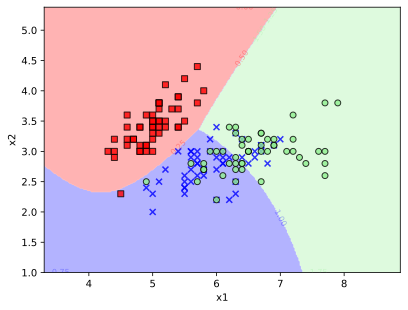

2024-09-08 15:35:34,449 - INFO - Train Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.65      0.74      0.69        50
           2       0.70      0.62      0.66        50

    accuracy                           0.78       150
   macro avg       0.78      0.78      0.78       150
weighted avg       0.78      0.78      0.78       150

2024-09-08 15:35:34,452 - INFO - Mislabeled points: 0.22


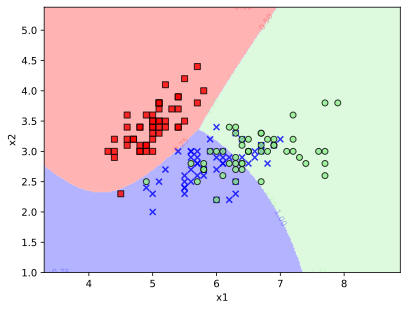

2024-09-08 15:35:34,582 - INFO - Train Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       250

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

2024-09-08 15:35:34,583 - INFO - Mislabeled points: 0.0


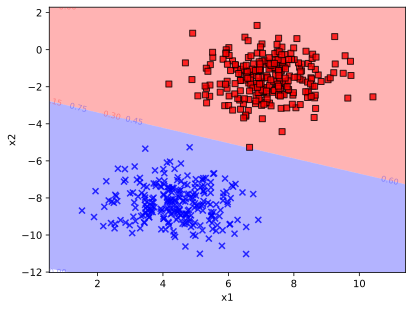

In [3]:
"""Main script to run the Naive Bayes algorithm."""
from __future__ import annotations

import warnings
from typing import Any

import numpy as np
from numpy.typing import NDArray
from sklearn.datasets import load_iris, make_blobs
from sklearn.naive_bayes import GaussianNB

from omnivault.machine_learning.utils import plot_classifier_decision_boundary, run_classifier
from omnivault.utils.reproducibility.seed import seed_all

warnings.filterwarnings("ignore", category=UserWarning)


def run_naive_bayes_sanity_check(
    X: NDArray[np.floating[Any]],
    my_estimator: NaiveBayesGaussian,
    sklearn_estimator: GaussianNB,
) -> None:
    """Run sanity check on our Naive Bayes implementation with sklearn's implementation by
    comparing the **fitted** parameters of the two estimators.

    Therefore, both estimators should be fitted before calling this function.

    NOTE:
        Recall our theta is of shape (num_classes, num_features, 2)
        where 3x4x2 is (3 classes, 4 features, 2 parameters)
        so first class is 4x2 and the column is the mean of each feature for class 1
        and the second column is the variance of each feature for class 1
        coincides with sklearn so we gucci.
    """

    # assert my_estimator.is_fitted, "My estimator is not fitted."

    my_pi = my_estimator.pi
    my_theta = my_estimator.theta
    my_mean = my_theta[:, :, 0]
    my_covariance = my_theta[:, :, 1]
    print(f"My Pi:\n{my_pi}")
    print(f"My Mean:\n{my_mean}")
    print(f"My Covariances:\n{my_covariance}")

    sk_pi = sklearn_estimator.class_prior_
    sk_theta = sklearn_estimator.theta_
    sk_covariance = sklearn_estimator.var_

    print(f"Sklearn Pi:\n{sk_pi}")
    print(f"Sklearn Mean:\n{sk_theta}")
    print(f"Sklearn Covariances:\n{sk_covariance}")

    np.testing.assert_allclose(my_pi, sk_pi)
    np.testing.assert_allclose(my_mean, sk_theta)
    np.testing.assert_allclose(my_covariance, sk_covariance)

    my_probs = my_estimator.predict_proba(X)
    # print(f"My Predict Proba:\n{my_probs}")

    sk_probs = sklearn_estimator.predict_proba(X)
    # print(f"Sklearn Predict Proba:\n{sk_probs}")

    np.testing.assert_allclose(my_probs, sk_probs, rtol=1e-2, atol=1e-2)

    if hasattr(my_estimator, "predict_log_proba"):
        print(my_estimator)
        print("Running log proba sanity check...")
        my_log_probs = my_estimator.predict_log_proba(X)
        # print(f"My Predict Log Proba:\n{my_log_probs}")

        sk_log_probs = sklearn_estimator.predict_log_proba(X)
        # print(f"Sklearn Predict Log Proba:\n{sk_log_probs}")

        np.testing.assert_allclose(my_log_probs, sk_log_probs, rtol=1e-2, atol=1e-2)


def plot_naive_bayes_decision_boundary(
    X: NDArray[np.floating[Any]],
    y: NDArray[np.floating[Any]],
    my_estimator: NaiveBayesGaussian,
    sk_estimator: GaussianNB,
) -> None:
    """Plot the decision boundary of the Naive Bayes classifier."""
    # plotting IRIS decision boundary requires us
    # to only subset the data to two features.

    # plot the decision boundary for IRIS with 2 features
    X_2d = X[:, :2]
    plot_classifier_decision_boundary(my_estimator, X_2d, y)
    plot_classifier_decision_boundary(sk_estimator, X_2d, y)


if __name__ == "__main__":
    seed_all(1992)
    X, y = load_iris(return_X_y=True)
    class_names = ["setosa", "versicolor", "virginica"]

    gnb = NaiveBayesGaussian(random_state=1992, num_classes=3)
    gnb = run_classifier(
        gnb,
        X,
        y,
        test_size=0.2,
        random_state=0,
        class_names=class_names,
    )

    sk_gnb = GaussianNB(var_smoothing=0)
    sk_gnb = run_classifier(
        sk_gnb,
        X,
        y,
        test_size=0.2,
        random_state=0,
        class_names=class_names,
    )

    run_naive_bayes_sanity_check(X, gnb, sk_gnb)

    # let's check for the log likelihood version
    # Numerical stability: Scikit-learn might use more numerically stable methods
    # for calculating log probabilities, which can lead to slightly different results.
    # For example, scikit-learn may use the log-sum-exp trick to avoid numerical
    # underflow or overflow issues.
    log_gnb = NaiveBayesGaussianLogLikelihood(random_state=1992, num_classes=3)
    log_gnb = run_classifier(log_gnb, X, y, test_size=0.2, random_state=0, class_names=class_names)
    run_naive_bayes_sanity_check(X, log_gnb, sk_gnb)

    # plot the decision boundary for IRIS with 2 features
    plot_naive_bayes_decision_boundary(X, y, gnb, sk_gnb)

    # let's try with blobs
    # pylint: disable=unbalanced-tuple-unpacking
    X, y = make_blobs(n_samples=500, centers=2, n_features=2, random_state=1992, return_centers=False)

    gnb = NaiveBayesGaussian(random_state=1992, num_classes=2)
    plot_classifier_decision_boundary(gnb, X, y)


## References And Further Readings

-   [Scikit-learn](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/naive_bayes.py)